# 2023.11.03 Given a list of camera poses, visualize the cameras in a 3D scene

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d.transforms as transformations
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.utils import *
import os.path as osp
import random
from datetime import datetime

# 2023.11.14 Visualize camera poses using pyramids (more intuitive)

In [2]:
from utils.camera_pose_visualizer import CameraPoseVisualizer


In [3]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "dumbbell_20231207_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/dumbbell_20231207_obj_frame


### Visualize poses in images.txt  (Before generating .json file)

In [4]:
def visualize_cam_poses_3D(T_camerainworld, plt_title="Visualize cameras in world frame", save_plot=False, show_plot=True, save_path=None, dpi=600, flip_transform=np.eye(4), focal_len_scaled=0.1, draw_idx=False, selected_idx=None):
    """
    
    """
    # Create 3D plot for visualization
    axis_margin = 0.01
    
    if len(T_camerainworld.shape) == 2:
        T_camerainworld = np.expand_dims(T_camerainworld, axis=0)

    T_camerainworld = T_camerainworld @ flip_transform
    print(f"Visualize {len(T_camerainworld)} camera poses in world frame")

    # obtain the min and max of all camera poses
    x_min = np.min(T_camerainworld[:, 0, 3]) - axis_margin
    x_max = np.max(T_camerainworld[:, 0, 3]) + axis_margin
    y_min = np.min(T_camerainworld[:, 1, 3]) - axis_margin
    y_max = np.max(T_camerainworld[:, 1, 3]) + axis_margin
    z_min = np.min(T_camerainworld[:, 2, 3]) - axis_margin
    z_max = np.max(T_camerainworld[:, 2, 3]) + axis_margin
    print(f"limit for all camera poses: x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}, z_min: {z_min}, z_max: {z_max}")

    visualizer = CameraPoseVisualizer([x_min, x_max], [y_min, y_max], [z_min, z_max])
    set_axes_equal(visualizer.ax)

    # Generate a list of random colors
    colormap = plt.get_cmap("viridis")
    num_colors = len(T_camerainworld)
    colors = [colormap(i / num_colors) for i in range(num_colors)]
    # Add camera poses in the world
    for i, color in zip(range(len(T_camerainworld)), colors):
        if selected_idx is not None and i not in selected_idx:
            continue
        visualizer.extrinsic2pyramid(T_camerainworld[i], color, focal_len_scaled=focal_len_scaled, idx=i, draw_idx=draw_idx)
    visualizer.show(plt_title=plt_title, save_plot=save_plot, show_plot=show_plot, save_path=save_path, dpi=dpi)

Visualize 202 camera poses in world frame
limit for all camera poses: x_min: -0.5401832330173467, x_max: 0.6363130671421515, y_min: -0.640085588192496, y_max: 0.6715027715424722, z_min: -0.04330662673992913, z_max: 0.48536976478515786
initialize camera pose visualizer


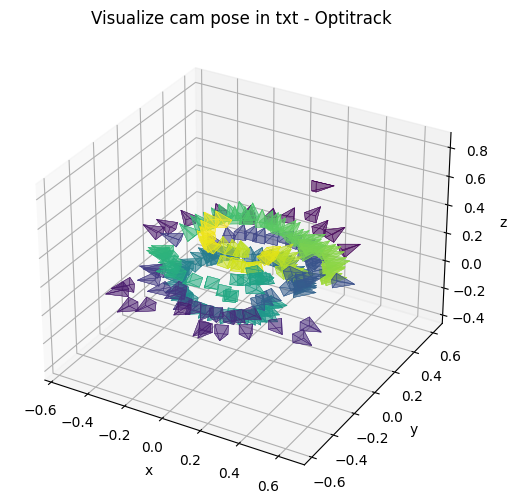

In [5]:
# Read images.txt and extract the camera poses
T_camerainworld_optitrack_txt = []
images_txt_path = osp.join(obj_dir, 'images_all.txt')
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        cam_pose = np.linalg.inv(T_worldincamera)
        T_camerainworld_optitrack_txt.append(cam_pose)

T_camerainworld_optitrack_txt = np.array(T_camerainworld_optitrack_txt)

visualize_cam_poses_3D(T_camerainworld_optitrack_txt, plt_title="Visualize cam pose in txt - Optitrack", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_txt_optitrack_{obj_name}.png", focal_len_scaled=0.1)

Visualize 202 camera poses in world frame
limit for all camera poses: x_min: -4.560390892362737, x_max: 5.4617292744684525, y_min: -2.730053967269514, y_max: 1.9920098117177842, z_min: -5.238453083120241, z_max: 5.6766703502097755
initialize camera pose visualizer


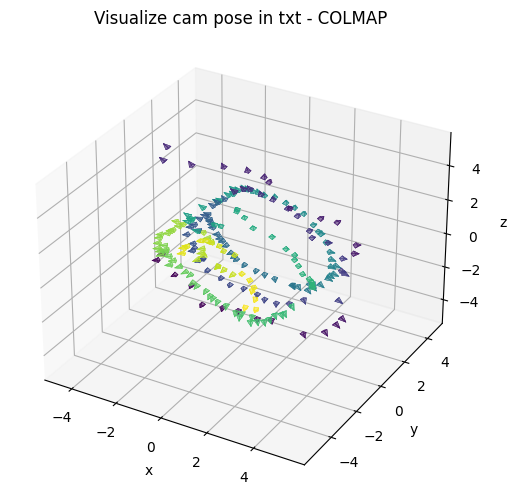

In [6]:
# Read images.txt and extract the camera poses
T_camerainworld_colmap_txt = []
images_txt_path = osp.join(obj_dir, 'colmap_text', 'images.txt')
img_ids = []
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        if i % 2 == 0:
            img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
            # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
            quat = np.array([float(qx), float(qy), float(qz), float(qw)])
            tvec = np.array([float(tx), float(ty), float(tz)])
            # convert to homogeneous transform matrix
            T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
            cam_pose = np.linalg.inv(T_worldincamera)
            T_camerainworld_colmap_txt.append(cam_pose)
            img_ids.append(img_id)


# sort the camera poses according to the image id
T_camerainworld_colmap_txt = [x for _,x in sorted(zip(img_ids, T_camerainworld_colmap_txt), key=lambda pair: int(pair[0]))]

T_camerainworld_colmap_txt = np.array(T_camerainworld_colmap_txt)

visualize_cam_poses_3D(T_camerainworld_colmap_txt, plt_title="Visualize cam pose in txt - COLMAP", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_txt_colmap_{obj_name}.png", focal_len_scaled=0.3)

### Visualize poses in transforms.json  (After generating .json file)

In [7]:
# Extract the camera poses from transforms.json file
def extract_camera_poses_from_json(json_path):
    """
    Input:
        json_path: path to the json file containing the camera poses
    Output:
        poses: a list of poses, each pose is a 4x4 numpy array 
    """
    import json
    with open(json_path) as f:
        data = json.load(f)

    # Note the camera poses are stored in the 'frames' field and each frame has file_path field to store the image name, e.g.   "file_path": "./images/00058.png",
    # Since json file is not sorted, we need to sort the frames by the file_path field
    sorted_frames = sorted(data['frames'], key=lambda k: k['file_path'].split('/')[-1])
    poses = []

    for i in range(len(sorted_frames)):
        pose = np.array(sorted_frames[i]['transform_matrix'])
        poses.append(pose)

    return np.array(poses)

In [8]:
# Visualize camera poses in transforms_colmap.json
json_colmap = osp.join(obj_dir, 'transforms_colmap.json')
json_optitrack = osp.join(obj_dir, 'transforms_optitrack.json')

poses_colmap = extract_camera_poses_from_json(json_colmap)
poses_optitrack = extract_camera_poses_from_json(json_optitrack)

# flip each pose by a transform. X-right, Y-down, Z-forward changes to X-right, Y-up, Z-backward
flip_transform = np.array([[1, 0, 0, 0],
                           [0, -1, 0, 0],
                           [0, 0, -1, 0],
                           [0, 0, 0, 1]])

print(f"poses_colmap shape {poses_colmap.shape}, poses_optitrack shape {poses_optitrack.shape}")

poses_colmap shape (202, 4, 4), poses_optitrack shape (202, 4, 4)


Visualize 202 camera poses in world frame
limit for all camera poses: x_min: -5.894518998359242, x_max: 6.210110300990052, y_min: -5.071903419077786, y_max: 6.248397133947685, z_min: -0.8441285063113121, z_max: 4.052527118659162
initialize camera pose visualizer


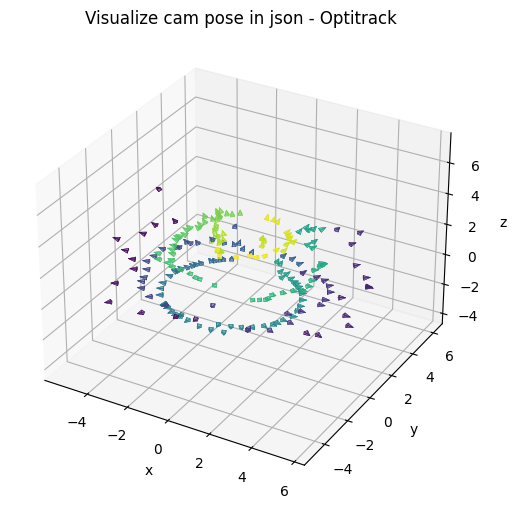

In [9]:
visualize_cam_poses_3D(poses_optitrack, plt_title="Visualize cam pose in json - Optitrack", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_json_optitrack_{obj_name}.png", flip_transform=flip_transform, focal_len_scaled=0.3) # 

Visualize 202 camera poses in world frame
limit for all camera poses: x_min: -5.713843138162166, x_max: 5.56601110228381, y_min: -4.972400560564073, y_max: 5.124814883042381, z_min: -0.8022683228690253, z_max: 3.609252005259517
initialize camera pose visualizer


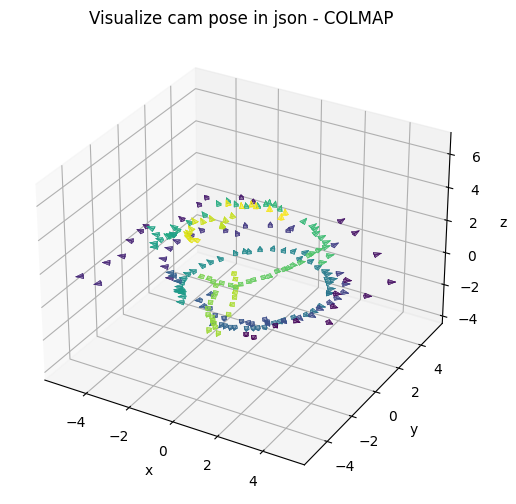

In [10]:
visualize_cam_poses_3D(poses_colmap, plt_title="Visualize cam pose in json - COLMAP", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_json_colmap_{obj_name}.png", focal_len_scaled=0.3, flip_transform=flip_transform) # 
# Note: the cameras are reversed because NeRF coordinate convention for cameras are +X is right, +Y is up, and +Z is pointing back and away from the camera. -Z is the look-at direction., which is the same for OpenGL/Blender

In [11]:
from verify_homogeneous_transform import  evaluate_transform # estimate_transform,

In [12]:
print(f"check shape poses_colmap {poses_colmap.shape}, poses_optitrack {poses_optitrack.shape}")

check shape poses_colmap (202, 4, 4), poses_optitrack (202, 4, 4)


In [14]:

# select a subset of poses to compute the transform

# # # filter by each segment
# # start_idx = 40
# # num_pose = 15
# # selected_poses_colmap = poses_colmap[start_idx:start_idx+num_pose, :3, 3]
# # selected_poses_optitrack = poses_optitrack[start_idx:start_idx+num_pose, :3, 3]

# all_indexes = np.arange(poses_colmap.shape[0])
# exception_indexes = [9, 20, 21, 22, 23, 49, 59, 60]
# selected_indexes = all_indexes[~np.isin(all_indexes, exception_indexes)]

# selected_poses_colmap = poses_colmap[selected_indexes, :3, 3]
# selected_poses_optitrack = poses_optitrack[selected_indexes, :3, 3]

# # source: optitrack; target: colmap
# print(f"check shape: target points: {selected_poses_colmap.shape} source {selected_poses_optitrack.shape}")


# Transform = estimate_transform(selected_poses_colmap, selected_poses_optitrack, verbose=False)
# evaluate_transform(selected_poses_colmap, selected_poses_optitrack, Transform, save_plot=False, show_plot=True, draw_idx=True)

In [13]:
def estimate_transform(points_original, points_transformed, verbose=False):
    """
    Given the coordinates of a set of points in two coordinate frames, estimate the homogeneous transform between two frames.
    Input:
        points_original: a list of points in the original coordinate frame, shape (N, 3)
        points_transformed: a list of points in the transformed coordinate frame, shape (N, 3)
    """
    # Convert the points to numpy arrays
    points_original = np.array(points_original)
    points_transformed = np.array(points_transformed)
    if verbose:
        print(
            f"check shape points_original: {points_original.shape} points_transformed: {points_transformed.shape}"
        )
    # Compute the centroid
    centroid_original = np.mean(points_original, axis=0)
    centroid_transformed = np.mean(points_transformed, axis=0)
    
    if verbose: 
        print(f"centroid_original: {centroid_original.shape} {centroid_original}")
    # Center the points
    centered_original = points_original - centroid_original
    print(f"after subtraction: centered_original: {centered_original.shape} ")
    centered_transformed = points_transformed - centroid_transformed
    # Compute the covariance matrix
    H = np.dot(centered_original.T, centered_transformed)
    # Use SVD to compute the rotation matrix
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    # Handle the reflection case
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)
    # Compute the translation
    t = centroid_transformed.T - np.dot(R, centroid_original.T)
    # Assemble the transformation matrix
    Transform = np.eye(4)
    Transform[:3, :3] = R
    Transform[:3, 3] = t
    return Transform


check shape: selected_poses_colmap (199, 3), selelcted_poses_optitrack (199, 3)
check shape points_original: (199, 3) points_transformed: (199, 3)
centroid_original: (3,) [-0.02114858 -0.37636458  1.13841983]
after subtraction: centered_original: (199, 3) 
Check errors shape (199,), min 0.004198453405141877, max 0.1641767626145994
check shape filtered_pts_index (199,), filted_out_pts_index (0,)
Find 199 points have error smaller than threshold, filter out 0 pts, index: [] 
In function evaluate_transform, 
Mean Squared Error: 0.0004956159663620887 
Total squared error 0.29588273191816694


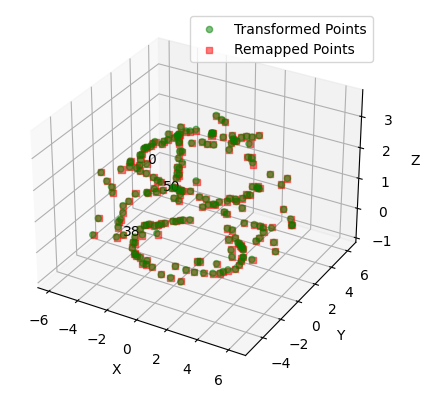

In [17]:
# Evaluate with all points 
all_poses_colmap = poses_colmap[:, :3, 3]
all_poses_optitrack = poses_optitrack[:, :3, 3]

all_indexes = np.arange(poses_colmap.shape[0])
exception_indexes = [0, 38, 50]
selected_indexes = all_indexes[~np.isin(all_indexes, exception_indexes)]

selected_poses_colmap = all_poses_colmap[selected_indexes]
selected_poses_optitrack = all_poses_optitrack[selected_indexes]
print(f"check shape: selected_poses_colmap {selected_poses_colmap.shape}, selelcted_poses_optitrack {selected_poses_optitrack.shape}")

# # check shape points_original: (55, 3) points_transformed: (55, 3)
# # centroid_original: (3,) [ 0.052693   -1.37772379  0.57728615]

# all_poses_colmap = poses_colmap
# all_poses_optitrack = poses_optitrack
# check shape points_original: (55, 4, 4) points_transformed: (55, 4, 4)
# centroid_original: (4, 4) [[ 2.82130081e-01 -9.46511503e-11  3.74037681e-02  5.26929980e-02]
#  [ 3.37719244e-02  1.22118737e-11 -2.80435819e-01 -1.37772379e+00]
#  [ 7.81137720e-02  9.62534920e-01  1.48071263e-01  5.77286146e-01]
#  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

# obtain today's date
today = datetime.today().strftime("%Y%m%d")

# Transform = estimate_transform(all_poses_colmap, all_poses_optitrack, verbose=True)
Transform = estimate_transform(selected_poses_colmap, selected_poses_optitrack, verbose=True)
save_path = f"logs/{today}_found_naughty_frames_{obj_name}.png"
evaluate_transform(selected_poses_colmap, selected_poses_optitrack, Transform, save_plot=False, show_plot=True, draw_idx=True, save_path=save_path, rank_error=True, idx_list=[0, 38, 50]) # , idx_list=exception_indexes

In [16]:
raise ValueError("Stop here to check")

ValueError: Stop here to check